Creating a database for an additional state

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os, osr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from geopandas import GeoDataFrame, GeoSeries, read_file
from shapely.geometry import Point, Polygon, MultiPolygon, shape
from shapely.prepared import prep
import shapely.ops as ops
from pandas import Series, DataFrame
from descartes import PolygonPatch
import fiona
import rasterio
from osgeo import gdal, ogr
from rtree import index
import shapefile
from itertools import *
from functools import partial
import pyproj
import pickle

In [2]:
# organsing file names
# data source
state_name = 'Washington'
year = '2010'
channels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6_VCID_2', 'B7']
folder_loc = 'LANDSAT_TOA/' + state_name + '/' 

[**Affine GeoTransform**](http://www.gdal.org/gdal_datamodel.html)

GDAL datasets have two ways of describing the relationship between raster positions (in pixel/line coordinates) and georeferenced coordinates. The first, and most commonly used is the affine transform (the other is GCPs).

The affine transform consists of six coefficients returned by GDALDataset::GetGeoTransform() which map pixel/line coordinates into georeferenced space using the following relationship:

$    X_{geo} = GT(0) + pixel_X*GT(1) + pixel_Y*GT(2)$ 

$    Y_{geo} = GT(3) + pixel_X*GT(4) + pixel_Y*GT(5)$

- In case of north up images, the GT(2) and GT(4) coefficients are zero. 
- GT(1) is pixel width
- GT(5) is pixel height 
- The (GT(0),GT(3)) position is the top left corner of the top left pixel of the raster.

In [3]:
def pixelToCoordinates(geotransform, column, row):
    x_origin = geotransform[0]
    y_origin = geotransform[3]
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]
    rotation_x = geotransform[2]
    rotation_y = geotransform[4]
    #
    lon_coord = x_origin + (column * pixel_width) + (row * rotation_x)
    lat_coord = y_origin + (column * rotation_y) + (row * pixel_height)
    #
    return (lon_coord, lat_coord)

In [4]:
data = []
count = 0
for extension in channels:
    filename = folder_loc + state_name + '_' + year + '_' + extension + '.tif'
    ds = gdal.Open(filename)
    # getting data
    if extension == 'B1':
        ncols, nrows = ds.RasterXSize, ds.RasterYSize
        print ncols, nrows, ncols*nrows
        rows_grid, cols_grid = np.meshgrid(range(0,ncols), range(0,nrows))
        cols_grid, rows_grid = rows_grid.flatten(), cols_grid.flatten()
        # getting a series of lat lon points for each pixel
        location_series = [Point(pixelToCoordinates(ds.GetGeoTransform(), col, row)) \
            for (col, row) in zip(cols_grid, rows_grid)]
        # pixel data
        band = ds.GetRasterBand(1)
        array = band.ReadAsArray()
        band_series = [array[row][col] for (col, row) in zip(cols_grid, rows_grid)]
        data.append(band_series)
    else:
        band = ds.GetRasterBand(1)
        array = band.ReadAsArray()
        band_series = np.array([array[row][col] for (col, row) in zip(cols_grid, rows_grid)])
        data.append(band_series)

db_image = GeoDataFrame({
    'location': location_series,
    'B1': data[0],
    'B2': data[1],
    'B3': data[2],
    'B4': data[3],
    'B5': data[4],
    'B6_VCID_2': data[5],
    'B7': data[6],
    })

885 386 341610


# Adding urban area data

Adding a column indicating whether the area was an urban area according to [US Census Bureau](https://www.census.gov/geo/maps-data/data/cbf/cbf_ua.html)

**Only one percent of Oregon pixels are in urban areas**

In [5]:
df_urban = GeoDataFrame.from_file('urban_areas/cb_2012_us_uac10_500k.shp')

In [6]:
# Only keeping urban areas in Oregon and Washington
df_urban_wa_or = df_urban[(df_urban['NAME10'].str.contains('WA', case=True))]

In [7]:
# Spatial index
urban_blocks = np.array(df_urban_wa_or['geometry'])
idx = index.Index()
count = 0
for u_block in urban_blocks:
    idx.insert(count, u_block.bounds)
    count += 1

# for each point
pixels_location = db_image['location']

In [8]:
pixel_urban = []
count = 0
for pixel in pixels_location:
    temp_polygon = None
    temp_urban = None
    for j in idx.intersection((pixel.x, pixel.y)):
        if pixel.within(urban_blocks[j]):
            temp_polygon = urban_blocks[j]
            temp_urban = 1
            break
    pixel_urban.append([count, temp_polygon, temp_urban, pixel.x, pixel.y])
    count += 1

In [9]:
pixel_urban = GeoDataFrame(pixel_urban)
pixel_urban.columns = ['count','poly', 'urban', 
                             'latitude', 'longitude']
db_image['urban'] = pixel_urban['urban']
db_image['latitude_u'] = pixel_urban['latitude']
db_image['longitude_u'] = pixel_urban['longitude']

In [10]:
# Only one percent of my pixels are in Urban areas!
db_image['urban'].sum() /db_image.shape[0]

0.029358039870027223

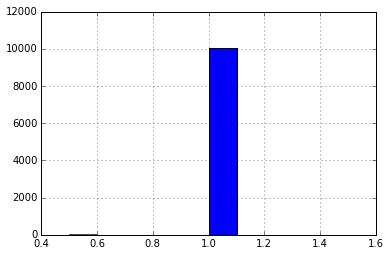

In [33]:
db_image['urban'].hist()

If I'm stratifying on Urban/Rural, then we can do this here.

Create images. Sample. Overlap is OK. Then repackage into a dataframe.

In [12]:
# For Keras
obs_size = 64
nrows, ncols = ds.RasterYSize, ds.RasterXSize
nobs = (nrows - obs_size) * (ncols - obs_size)

In [13]:
df_image = []
for i in range(len(data)):
    df_image.append( np.array(data[i]).reshape((nrows, ncols)) )

df_image = np.array(df_image)

In [14]:
urban_array = db_image['urban'].fillna(0)
urban_array = np.array(urban_array).reshape((nrows, ncols))

In [15]:
urban_data = []
for i in range(0, nrows - obs_size, 1):
    j = 0
    for j in range(0, ncols - obs_size, 1):
        urb_px = urban_array[i : i + obs_size, j : j + obs_size].sum()
        urban_data.append(urb_px)
        

In [16]:
urban_data = DataFrame(urban_data)

#### After looking at the histogram, let's have four buckets. 

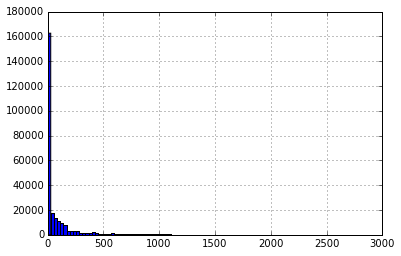

In [36]:
urban_data[0].hist(bins=100)

In [17]:
sampling_rate = 0.1
urban_rank = urban_data[0].rank(ascending=True)
urban_data['rank'] = urban_rank
sumrank = urban_data['rank'].sum()
urban_data['weight'] = (urban_data['rank']**20) / sumrank
urban_sample = urban_data[0].sample(
    int(len(urban_data[0]) * sampling_rate), 
    weights=urban_data['weight'], replace=True)

In [18]:
urban_sample_idx = np.array(urban_sample.index.values)
urban_sample_idx.sort()

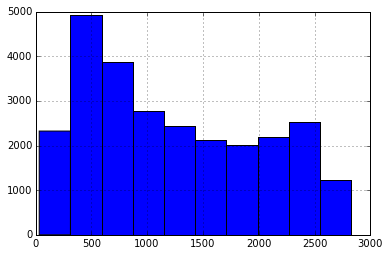

In [19]:
urban_data[0][urban_sample_idx].hist()

### Getting shape file

In [20]:
df_shape = GeoDataFrame.from_file(
#    'county_2010_census/County_2010Census_DP1.shp')
    'washington_block_data/tabblock2010_53_pophu.shp')
#    'oregon_block_data/tabblock2010_41_pophu.shp')

**AREA**

In [21]:
# It turns out the earth isn't flat
# Getting area in square kilometers

area_sq_degrees = df_shape['geometry']
area_sq_km = []

for region in area_sq_degrees:
    geom_area = ops.transform(
        partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat1=region.bounds[1],
            lat2=region.bounds[3])),
        region)
    area = geom_area.area / 1e6 # convert to km2
    area_sq_km.append( area )

df_shape['area'] = area_sq_km

In [22]:
df_shape['density'] = df_shape['POP10'] / df_shape['area']

### Sampling

[There will be a lot of space with few people there](https://en.wikipedia.org/wiki/Oregon#Major_cities)

- 4 million people live in Oregon
- Portland is the biggest city, with 600000 people
- Around 25% of population live in four cities

Approximately 44% of cells are empty.

This is resulting in a model that is confused: underpredicting areas with population, overpredicting areas with no population.

### Spatial index

In [23]:
blocks = df_shape['geometry']
idx = index.Index()
count = 0
for block in blocks:
    idx.insert(count, block.bounds)
    count += 1

# for each point
pixels_location = db_image['location']

### Merging 
The Satellite image information with the Census data information
- the Satellite image is a matrix of pixels
- each pixel has a latitute and longitude

To get population density for each pixel
- take the lat lon of the center of the pixel
- find out which census block this lies in
- assign the population density of the census block to the pixel

Questions that need to be answered:
    - How big is a pixel?
        - Around half a square kilometre
    - How big are census blocks?
        - Around three pixels

In [24]:
pixel_information = []
pixel_info_simple = []
count = 0
for pixel in pixels_location:
    temp_polygon = None
    temp_density = None
    for j in idx.intersection((pixel.x, pixel.y)):
        if pixel.within(blocks[j]):
            temp_polygon = blocks[j]
            temp_density = df_shape['density'][j]
            break
    pixel_information.append([count, temp_polygon, temp_density, pixel.x, pixel.y])
    count += 1

In [25]:
pixel_information = GeoDataFrame(pixel_information)
pixel_information.columns = ['count','poly', 'pop_density', 
                             'latitude', 'longitude']
db_image['pop_density'] = pixel_information['pop_density']
db_image['latitude'] = pixel_information['latitude']
db_image['longitude'] = pixel_information['longitude']

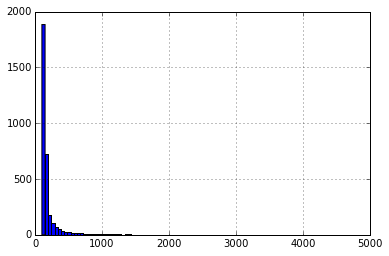

In [26]:
db_image[(db_image['urban']!=1) & (db_image['pop_density']>100)]['pop_density'].hist(bins=100)

### Some statistics about the database - so we can stratify

For reference, the [area](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area) of 
- Oregon is 255,000 km$^2$
- Washington is 185,000 km$^2$

The [population](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population) of
- Oregon is 3.8 million
- Washington is 6.7 million

In [27]:
state_area = df_shape['area'].sum()
no_pixels = db_image.shape[0]
area_per_pixel = state_area / no_pixels
average_census_block_area = df_shape['area'].mean()

In [28]:
# Pixels are smaller than blocks on average
area_per_pixel / average_census_block_area

0.57250665964111125

In [29]:
num_urban_pixels = db_image[db_image['urban']==1].shape[0]
num_rural_pixels = db_image[db_image['urban']!=1].shape[0]
share_pixels_urban = num_urban_pixels / float(num_rural_pixels) 
area_urban = num_urban_pixels * area_per_pixel
area_rural = num_rural_pixels * area_per_pixel

In [30]:
urban_density = db_image[db_image['urban']==1]['pop_density'].mean()
rural_density = db_image[db_image['urban']!=1]['pop_density'].mean()

In [31]:
urban_pop = urban_density * area_urban
rural_pop = rural_density * area_rural
total_pop = urban_pop + rural_pop
urban_pop_share = urban_pop / total_pop 

In [32]:
urban_pop_share

0.81177565437309784

- take urban and rural areas
- 80% of population live in urban areas
- 20% of population live in rural areas

+ So take 80% of sample from urban areas
+ 20% of sample from rural areas

Rather than 1% of sample from urban areas

sample_id

In [33]:
# For Keras
obs_size = 64
nrows, ncols = ds.RasterYSize, ds.RasterXSize
nobs = (nrows - obs_size) * (ncols - obs_size)

output_data_full = []
pop_output_data = []

df_pop = db_image['pop_density']
df_pop = df_pop.reshape((nrows, ncols))

In [34]:
df_image = []
for i in range(len(data)):
    df_image.append( np.array(data[i]).reshape((nrows, ncols)) )

df_image = np.array(df_image)

In [35]:
df_image.shape, nrows, ncols

((7, 386, 885), 386, 885)

In [ ]:
sample_id = urban_sample_idx
loop_completer = [0]
sample_id = np.append(sample_id, loop_completer)
count = 0
i = 0
# adding steps for fewer pixels
for i in range(0, nrows - obs_size, 1):
    j = 0
    for j in range(0, ncols - obs_size, 1):
        if count == sample_id[0]:
            obs_0 = df_image[0, i : i + obs_size, j : j + obs_size]
            obs_1 = df_image[1, i : i + obs_size, j : j + obs_size]
            obs_2 = df_image[2, i : i + obs_size, j : j + obs_size]
            obs_3 = df_image[3, i : i + obs_size, j : j + obs_size]
            obs_4 = df_image[4, i : i + obs_size, j : j + obs_size]
            obs_5 = df_image[5, i : i + obs_size, j : j + obs_size]
            obs_6 = df_image[6, i : i + obs_size, j : j + obs_size]
            output_data_full.append([obs_0, obs_1, obs_2, obs_3, obs_4, obs_5, obs_6])
            #
            obs_pop = df_pop[i : i  + obs_size, j : j + obs_size]
            pop_output_data.append(np.mean(obs_pop))
            #
            if sample_id[0] != sample_id[1]:
                sample_id = np.delete(sample_id,0)
            else:
                count -= 1
        j += 1
        count += 1
    i += 1


In [ ]:
pop_output_data = np.nan_to_num(np.array(pop_output_data))
output_data_full = np.array(output_data_full)

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

output_data_full, pop_output_data = shuffle_in_unison_inplace(output_data_full, pop_output_data)

In [ ]:
#testing_data = [output_data, pop_output_data]
#output = open('dataset_' + state_name + '_sml.pkl', 'wb')
# Pickle dictionary using protocol 0.
#pickle.dump(testing_data, output)
#output.close()

#testing_data_full = [output_data_full, pop_output_data]ls
#output_full = open('dataset_' + state_name + '.pkl', 'wb')
# Pickle dictionary using protocol 0.
#pickle.dump(testing_data_full, output_full)
#output_full.close()

Have to shuffle data! The validation in Keras is always on the last X% of the data.

This means the model's being validated on the southern most row.

In [ ]:
# X variables
file_size = 128
no_files = 1 + output_data_full.shape[0] / file_size 
count = 0
print 'Number of files', no_files
for i in range(0, no_files):
    temp = output_data_full[0:file_size, :, :, :]
    output = open('keras_data/db_X_' + state_name + '_%d.pkl' % count, 'wb')
    pickle.dump(temp, output)
    output.close()
    output_data_full = output_data_full[file_size:, :, :, :]
    count += 1

In [ ]:
# Y variables
file_size = 128
count = 0
print 'Number of files', no_files
for i in range(0, no_files):
    temp = pop_output_data[0:file_size, :, :, :]
    output = open('keras_data/db_y_' + state_name + '_%d.pkl' % count, 'wb')
    pickle.dump(temp, output)
    output.close()
    pop_output_data = pop_output_data[file_size:, :, :, :]
    count += 1